Import dependencies and configure settings.

In [1]:
import os
import csv
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as stats
import statsmodels.api as sm

import hawkes
import markDistributions as md
import scipy.optimize as op

from pylab import rcParams
from __future__ import division

%matplotlib inline
np.set_printoptions(precision=10)

Load data.

In [2]:
dat = 'GOOG_2012-06-21_34200000_57600000_message_10'
temp = ([],[],[],[],[],[])
with open('../../data/'+dat+'.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        temp[0].append(float(row[0]))
        temp[1].append(int(row[1]))
        temp[2].append(int(row[2]))
        temp[3].append(int(row[3]))
        temp[4].append(int(row[4]))
        temp[5].append(int(row[5]))

orders = {'Time':None, 'Type':None, 'Order ID':None,
        'Volume':None, 'Price':None, 'Direction':None}
orders['Time'] = np.asarray(temp[0])
orders['Type'] = np.asarray(temp[1])
orders['Order ID'] = np.asarray(temp[2])
orders['Volume'] = np.asarray(temp[3])
orders['Price'] = np.asarray(temp[4])
orders['Direction'] = np.asarray(temp[5])
del temp

In [3]:
ttemp = len(orders['Type'])
print("{0} order messages total:".format(len(orders['Type'])))
temp = len(orders['Type'][orders['Type']==1])
print("- {0} LO submissions ({1:.2f}%)".format(temp,100*temp/ttemp))
temp = len(orders['Type'][orders['Type']==2])
print("- {0} partial LO cancellations ({1:.2f}%)".format(temp,100*temp/ttemp))
temp = len(orders['Type'][orders['Type']==3])
print("- {0} LO cancellations ({1:.2f}%)".format(temp,100*temp/ttemp))
temp = len(orders['Type'][orders['Type']==4])
print("- {0} visible LO execution ({1:.2f}%)".format(temp,100*temp/ttemp))
temp = len(orders['Type'][orders['Type']==5])
print("- {0} hidden LO execution ({1:.2f}%)".format(temp,100*temp/ttemp))
temp = len(orders['Type'][orders['Type']==7])
print("- {0} trading halts ({1:.2f}%)".format(temp,100*temp/ttemp))
del ttemp
del temp

147916 order messages total:
- 71258 LO submissions (48.17%)
- 19 partial LO cancellations (0.01%)
- 64961 LO cancellations (43.92%)
- 7765 visible LO execution (5.25%)
- 3913 hidden LO execution (2.65%)
- 0 trading halts (0.00%)


Extract data into usable form.

In [4]:
LTC_mask = (orders['Type']==1) | (orders['Type']==3) | (orders['Type']==4)
t = orders['Time'][LTC_mask]
x = orders['Volume'][LTC_mask]

j = orders['Type'][LTC_mask]
j[(j==1) & (orders['Direction'][LTC_mask]==-1)] = 0 # limit ask orders
j[(j==1) & (orders['Direction'][LTC_mask]==1)] = 1 # limit bid orders
j[(j==3) & (orders['Direction'][LTC_mask]==-1)] = 2 # limit ask orders cancellation
j[(j==3) & (orders['Direction'][LTC_mask]==1)] = 3 # limit bid orders cancellation
j[(j==4) & (orders['Direction'][LTC_mask]==1)] = 4 # market ask orders
j[(j==4) & (orders['Direction'][LTC_mask]==-1)] = 5 # market bid orders

Initialise a 6-D Hawkes point process and set the parameters.

In [5]:
sparam =[  0.2655821625,   0.2467706365,   0.2488595796,   0.2334196466,   0.0299931322,
   0.0275962919,   0.182111157,    0.0221222508,   0.4824290013,   0.1766814967,
   0.6791265038,   0.3845468916,   0.005365127,    0.1768301375,   0.102805278,
   0.4755566209,   0.3431998706,   0.7105693583,   0.4359995561,   0.1105672259,
   0.1646056628,   0.0026448732,   0.2180595295,   0.4651086535,   0.1036088955,
   0.4019705048,   0.0099944545,   0.185940748,    0.4512819143,   0.2157649044,
   0.0056324858,   0.0057599176,   0.0013837344,   0.0032767781,   0.6608806473,
   0.0037258582,   0.0079340917,   0.0047258357,   0.0059642156,   0.00001,
   0.0094382205,   0.6776540789,  10.,            10.,            10.,            10.,
  10.,            10.,            73.0349372448, 0.,             1.9660371753,
   0.0006869116,   0.8673730157,  25.8972730011,   5.8284634569,   0.0079625467,
   7.1141382424,   0.0245273974,   3.5246200308,   0.0204672999]

In [6]:
d = 6
h = hawkes.Hawkes(d=d)
h.setParam(sparam)
print('Spr(Q)='+str(h.ibParam.getSpectralRadius()))

Spr(Q)=0.848014699666


In [7]:
markDistParam = [[128.56423972,3.275861426],
                [243.9044504278,4.3688862849],
                [97.8188721767,2.4801852406],
                [339.2756753572,5.8696885604],
                [460.4339503846,8.0904052855],
                [1115.865179198,18.8074665174]]
h.setMarkDistParam(markDistParam)

Simulation:

In [8]:
numPoints = 147916
simulatedPoints, simulatedIntensities = h.simulate(numPoints)
t, j, x = simulatedPoints

Order flow events analysis:

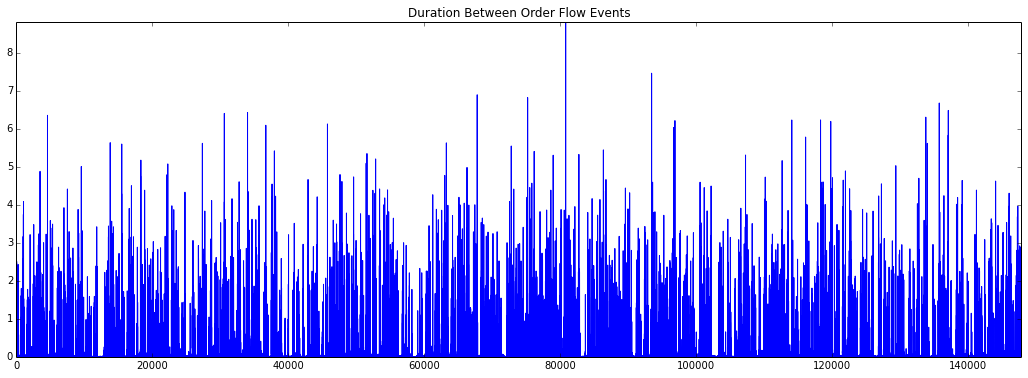

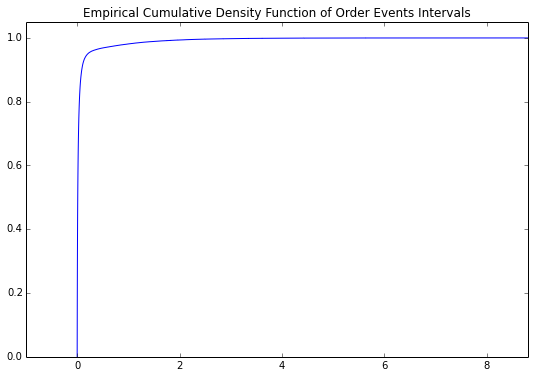

In [9]:
O_t = t
O_int = np.diff(O_t)

rcParams['figure.figsize'] = 18, 6
plt.plot(np.arange(len(O_int)), O_int)
plt.title('Duration Between Order Flow Events')
plt.axis([0, len(O_int), min(O_int), max(O_int)])
plt.show()

ecdf = sm.distributions.ECDF(O_int)
x = np.sort(O_int)
y = ecdf(x)

rcParams['figure.figsize'] = 9, 6
plt.step(x, y)
plt.title('Empirical Cumulative Density Function of Order Events Intervals')
plt.axis([min(x)-1, max(x), min(y), max(y)+0.05])
plt.show()

del ecdf
del x
del y

Market order submission interval:

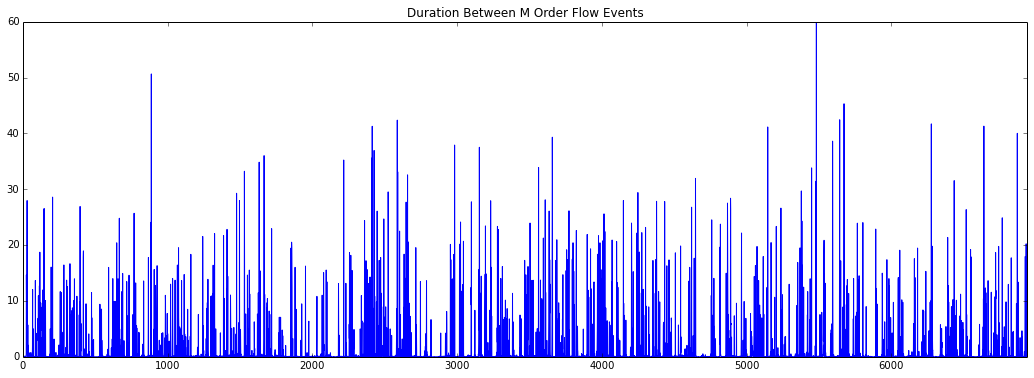

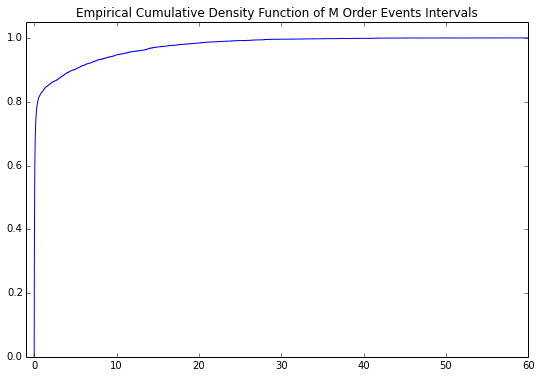

In [10]:
MO_t = t[(j==4) | (j==5)]
MO_int = np.diff(MO_t)

rcParams['figure.figsize'] = 18, 6
plt.plot(np.arange(len(MO_int)), MO_int)
plt.title('Duration Between M Order Flow Events')
plt.axis([0, len(MO_int), min(MO_int), max(MO_int)])
plt.show()

ecdf = sm.distributions.ECDF(MO_int)
x = np.sort(MO_int)
y = ecdf(x)

rcParams['figure.figsize'] = 9, 6
plt.step(x, y)
plt.title('Empirical Cumulative Density Function of M Order Events Intervals')
plt.axis([min(x)-1, max(x), min(y), max(y)+0.05])
plt.show()

del ecdf
del x
del y

LO submission arrivals:

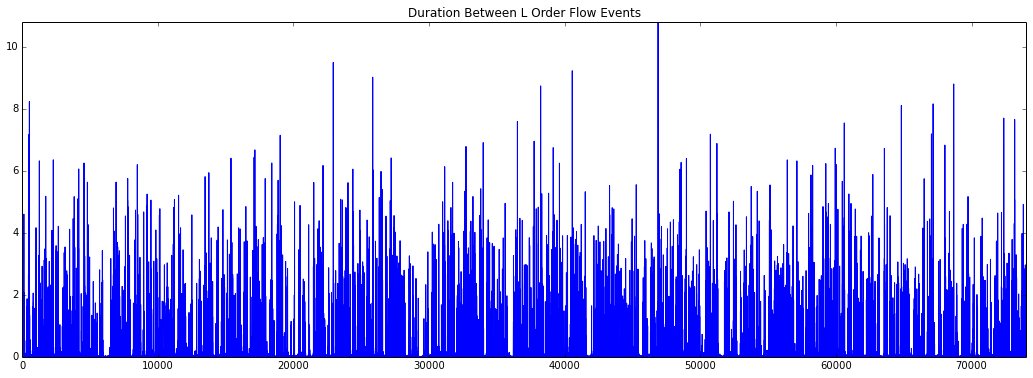

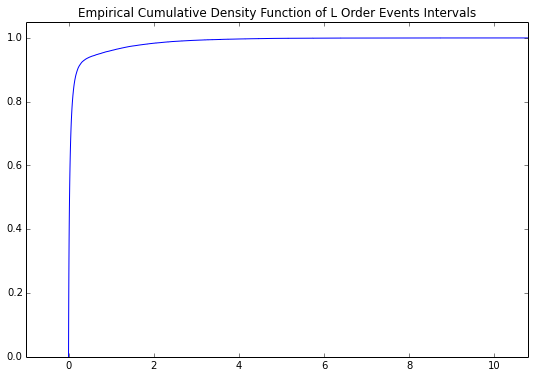

In [11]:
LO_t = t[(j==0) | (j==1)]
LO_int = np.diff(LO_t)

rcParams['figure.figsize'] = 18, 6
plt.plot(np.arange(len(LO_int)), LO_int)
plt.title('Duration Between L Order Flow Events')
plt.axis([0, len(LO_int), min(LO_int), max(LO_int)])
plt.show()

ecdf = sm.distributions.ECDF(LO_int)
x = np.sort(LO_int)
y = ecdf(x)

rcParams['figure.figsize'] = 9, 6
plt.step(x, y)
plt.title('Empirical Cumulative Density Function of L Order Events Intervals')
plt.axis([min(x)-1, max(x), min(y), max(y)+0.05])
plt.show()

del ecdf
del x
del y

Cancellation order intervals:

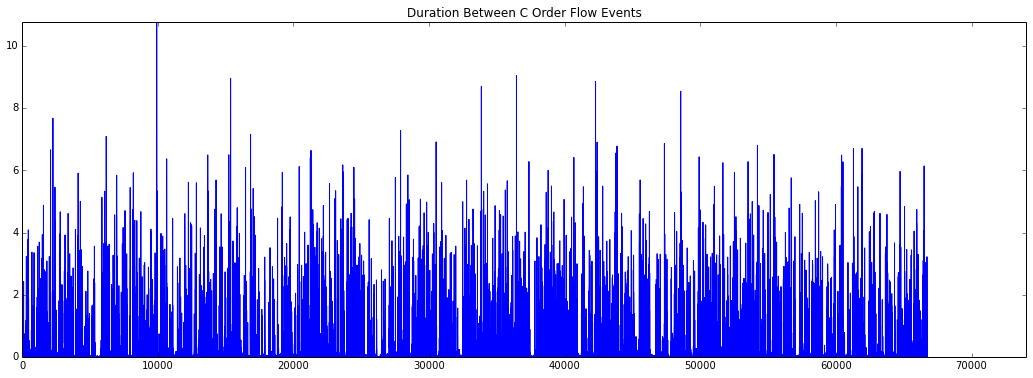

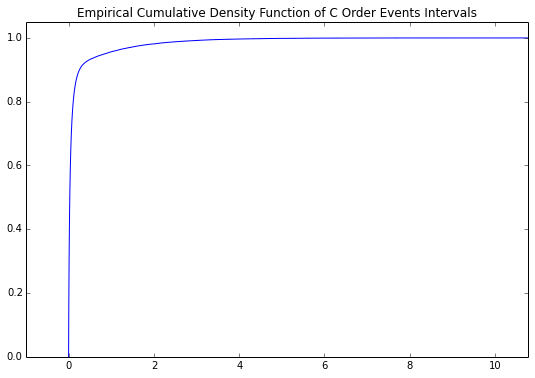

In [12]:
CO_t = t[(j==2) | (j==3)]
CO_int = np.diff(CO_t)

rcParams['figure.figsize'] = 18, 6
plt.plot(np.arange(len(CO_int)), CO_int)
plt.title('Duration Between C Order Flow Events')
plt.axis([0, len(LO_int), min(CO_int), max(CO_int)])
plt.show()

ecdf = sm.distributions.ECDF(CO_int)
x = np.sort(CO_int)
y = ecdf(x)

rcParams['figure.figsize'] = 9, 6
plt.step(x, y)
plt.title('Empirical Cumulative Density Function of C Order Events Intervals')
plt.axis([min(x)-1, max(x), min(y), max(y)+0.05])
plt.show()

del ecdf
del x
del y